# Cogs 118C, WI 2025

## Final project

### Elizabeth Kudriavtsev, Ameya Sapatnekar, Ricardo Lopez, Arthur Duong

In [ ]:
!pip install wfdb numpy pandas matplotlib scipy scikit-learn

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb

df = pd.read_csv("100.csv", header=0)

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 1.7 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.5 MB 1.7 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.5 MB 1.7 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.5 MB 1.7 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/11.5 MB 1.7 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.5 MB 1.6 MB/s eta 0:00:06
   --------- ------------------------------ 2.6/11.5 MB 1.6 MB/s eta 0:00:06
   ---------- ----------------------------- 2.9/11.5 MB 1.6 MB/s eta 0:00:06
   ---------- ----------------------------- 3.1/11.5 MB 1.6 MB/s eta 0:00:06
   ------------ --------------------------- 3.7/11.5 MB 1.6 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/11.5 MB 1.6 MB/s eta 0:00:05
   ----------

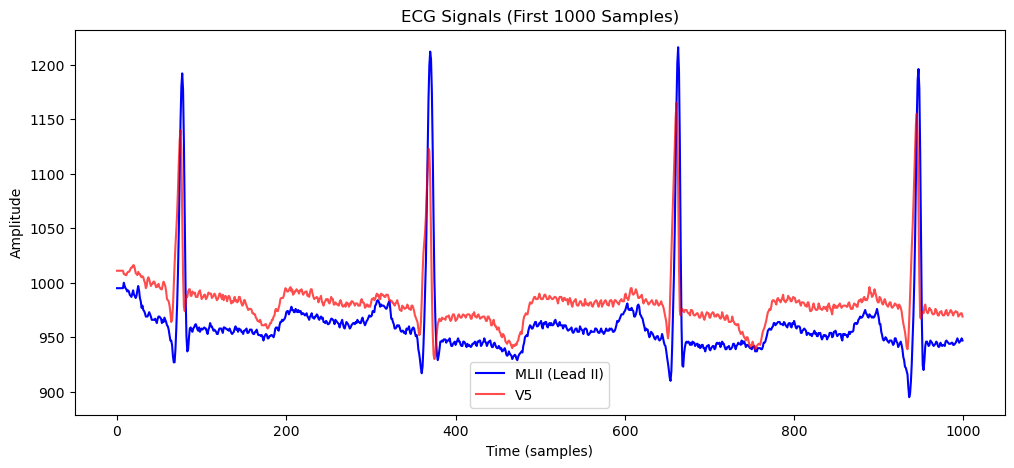

   Sample  MLII    V5
0       0   995  1011
1       1   995  1011
2       2   995  1011
3       3   995  1011
4       4   995  1011


In [3]:
# Clean column names, remove extra quotes and spaces 
df.columns = df.columns.str.replace("''", "", regex=False).str.replace("'", "", regex=False).str.strip()
df = df.apply(pd.to_numeric, errors='coerce')
df.rename(columns={"sample #": "Sample"}, inplace=True)

#2 ECG channels
signal_1 = df["MLII"]  # Lead II (MLII)
signal_2 = df["V5"]    # Precordial Lead V5

# Segment of the signals (first 1000 samples)
plt.figure(figsize=(12, 5))
plt.plot(df["Sample"][:1000], signal_1[:1000], label="MLII (Lead II)", color="blue")
plt.plot(df["Sample"][:1000], signal_2[:1000], label="V5", color="red", alpha=0.7)

# Plot labels
plt.legend()
plt.title("ECG Signals (First 1000 Samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

print(df.head())

Load and Process Annotations (100annotations.txt)
Convert time-based annotations into sample indices.

In [4]:
# Read the annotation file and skip the first row (which is the header)
annotations = pd.read_csv("100annotations.txt", delimiter="\t", header=None, skiprows=1, engine='python')

# Split the first column by whitespace and expand into multiple columns
annotations_split = annotations[annotations.columns[0]].str.split(r'\s+', expand=True)

# Assign proper column names after the split
annotations_split.columns = ['recording', 'Time', 'Type', 'Sub', 'Chan', 'Num', 'Aux']

# Display the cleaned annotations
print("\nCleaned Annotations:")
print(annotations_split.head(10))

### Time ###

sampling_rate=360 #hz
# Print the first few values of the 'Time' column to inspect the format
print("\nFirst few time values in the dataset:")
print(annotations_split['Time'].head(10))

# Apply the function to convert the 'Time' column to sample indices
def time_to_samples(time_str):
    if not time_str or time_str.strip() == "":
        print(f"Skipping empty or invalid time value: {time_str}")  # Debug print
        return None  # Skip empty strings or invalid times
    
    try:
        print(f"Processing time: {time_str}")  # Debug print
        # Split the time string into minutes, seconds, and milliseconds
        minutes, seconds_ms = time_str.split(':')
        seconds, milliseconds = seconds_ms.split('.')
        
        # Convert everything to seconds
        total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) / 1000
        
        # Calculate the sample index
        sample_index = int(total_seconds * sampling_rate)
        
        print(f"Total seconds: {total_seconds}, Sample index: {sample_index}")  # Debug print
        return sample_index
    except Exception as e:
        print(f"Error processing time: {time_str}. Error: {e}")
        return None

# Apply the function to the 'Time' column
annotations_split['Sample Index'] = annotations_split['Time'].apply(time_to_samples)

# Check for empty or invalid time entries
invalid_times = annotations_split[annotations_split['Sample Index'].isna()]

# Print out invalid time entries to understand the issue
print("\nInvalid time entries:")
print(invalid_times)

# Drop rows where 'Sample Index' is NaN
annotations_split.dropna(subset=['Sample Index'], inplace=True)

# Display the cleaned annotations with sample indices
print("\nAnnotations with Sample Indices:")
print(annotations_split.head(10))






Cleaned Annotations:
  recording      Time  Type Sub Chan Num Aux
0            0:00.050    18   +    0   0   0
1            0:00.214    77   N    0   0   0
2            0:01.028   370   N    0   0   0
3            0:01.839   662   N    0   0   0
4            0:02.628   946   N    0   0   0
5            0:03.419  1231   N    0   0   0
6            0:04.208  1515   N    0   0   0
7            0:05.025  1809   N    0   0   0
8            0:05.678  2044   A    0   0   0
9            0:06.672  2402   N    0   0   0

First few time values in the dataset:
0    0:00.050
1    0:00.214
2    0:01.028
3    0:01.839
4    0:02.628
5    0:03.419
6    0:04.208
7    0:05.025
8    0:05.678
9    0:06.672
Name: Time, dtype: object
Processing time: 0:00.050
Total seconds: 0.05, Sample index: 18
Processing time: 0:00.214
Total seconds: 0.214, Sample index: 77
Processing time: 0:01.028
Total seconds: 1.028, Sample index: 370
Processing time: 0:01.839
Total seconds: 1.839, Sample index: 662
Processing time: 


Identify different arrhythmia types (e.g., 'N' for normal, 'A' for arrhythmic beats).
Align them with the ECG signal.

In [7]:
# Define the ECG signal columns
ecg_columns = ['MLII', 'V5']  # These are the two electrode recordings

# Create a DataFrame for annotated ECG
annotated_ecg = pd.DataFrame({
    'Sample Index': annotations_split['Sample Index'],
    'Annotation Type': annotations_split['Type']
})

# Add both ECG signal values (from MLII and V5) at the corresponding sample indices
annotated_ecg['ECG Signal MLII'] = df[ecg_columns[0]].iloc[annotated_ecg['Sample Index']].values
annotated_ecg['ECG Signal V5'] = df[ecg_columns[1]].iloc[annotated_ecg['Sample Index']].values

# Display the annotated ECG data
print(annotated_ecg.head())


   Sample Index Annotation Type  ECG Signal MLII  ECG Signal V5
0            18              18              990           1014
1            77              77             1192           1066
2           370             370             1212           1096
3           662             662             1201           1146
4           946             946             1186           1133


Visualize ECG Segments Around Arrhythmias
Plot a window (e.g., ±100 samples) around each arrhythmic event.
Compare how MLII and V5 behave during these events.

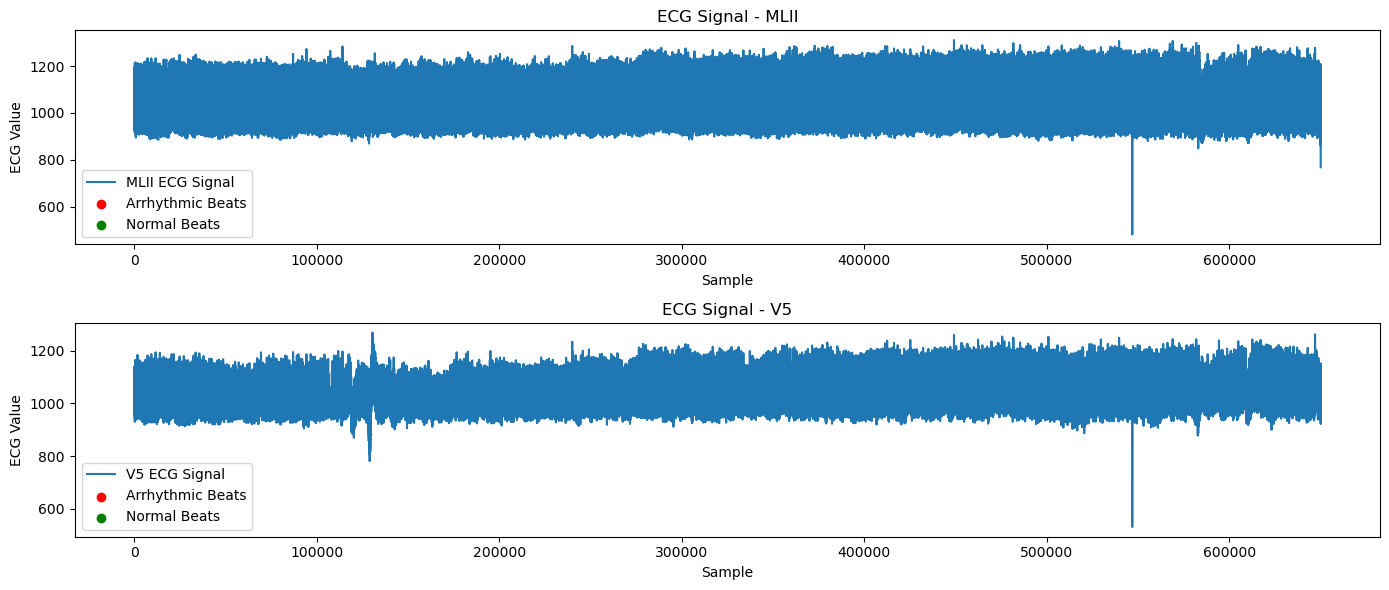

In [8]:
import matplotlib.pyplot as plt

# Example: Filter the annotations for arrhythmic events
arrhythmic_annotations = annotated_ecg[annotated_ecg['Annotation Type'] == 'A']  # 'A' for arrhythmic beats
normal_annotations = annotated_ecg[annotated_ecg['Annotation Type'] == 'N']  # 'N' for normal beats

# Plot ECG signal for both 'MLII' and 'V5' leads
plt.figure(figsize=(14, 6))

# Plot the MLII ECG signal
plt.subplot(2, 1, 1)
plt.plot(df['Sample'], df['MLII'], label='MLII ECG Signal')
plt.scatter(arrhythmic_annotations['Sample Index'], arrhythmic_annotations['ECG Signal MLII'], color='red', label='Arrhythmic Beats')
plt.scatter(normal_annotations['Sample Index'], normal_annotations['ECG Signal MLII'], color='green', label='Normal Beats')
plt.title('ECG Signal - MLII')
plt.xlabel('Sample')
plt.ylabel('ECG Value')
plt.legend()

# Plot the V5 ECG signal
plt.subplot(2, 1, 2)
plt.plot(df['Sample'], df['V5'], label='V5 ECG Signal')
plt.scatter(arrhythmic_annotations['Sample Index'], arrhythmic_annotations['ECG Signal V5'], color='red', label='Arrhythmic Beats')
plt.scatter(normal_annotations['Sample Index'], normal_annotations['ECG Signal V5'], color='green', label='Normal Beats')
plt.title('ECG Signal - V5')
plt.xlabel('Sample')
plt.ylabel('ECG Value')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Calculate Channel Correlation
Compute the Pearson correlation between MLII and V5 over time.
Identify changes in correlation during arrhythmias.

In [20]:
### Pearson Correlation over time (time windows I assume maybe?)

from scipy.stats import pearsonr

### for ease of doing, split into two different dataframes I think, MLII and V5

df_MLII = df['MLII']
df_V5 = df['V5']

Fs = 360

window = Fs * 300 
### window size  is x/Fs (example is 5 minutes) seconds for pearson correlation
### this takes a WHILE cuz the data is so large
correlation_coeffs = []
### make empty list for all the pearson correlations calculated in the time windows in the loop
for n in range(len(df['Sample'] - window + 1)):
    window_df_MLII = df_MLII[n: n + window]
    window_df_V5 = df_V5[n: n +  window]
    correlation, _ = pearsonr(window_df_MLII, window_df_V5)
    correlation_coeffs.append(correlation)
    


KeyboardInterrupt: 

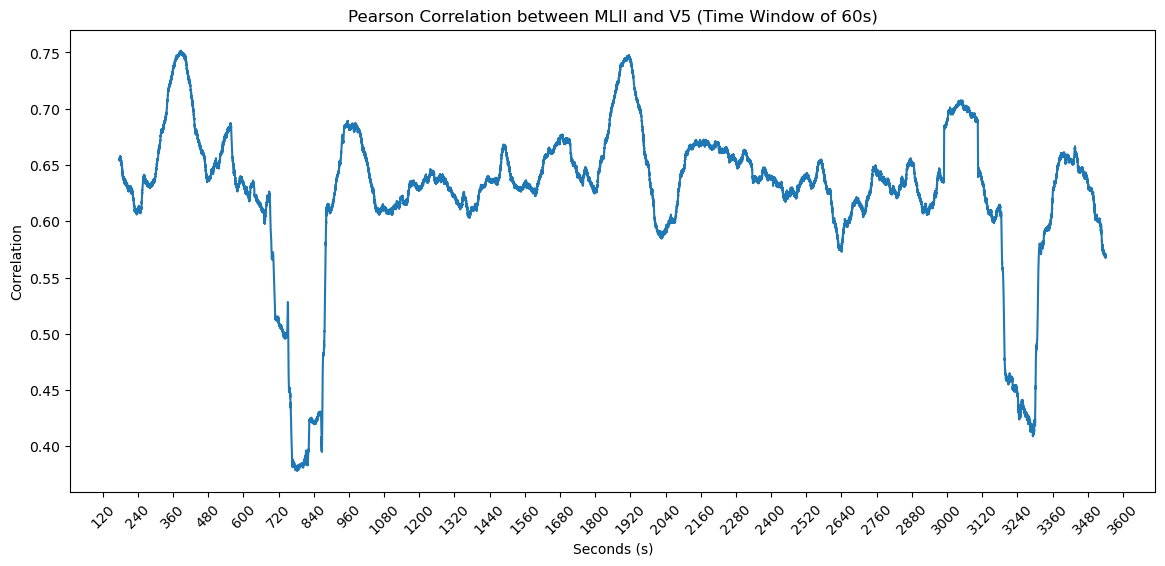

In [37]:
### Attempt 2 using different method:

plt.figure(figsize=(14, 6))

pearson = df_MLII.rolling(window = (60 * Fs), center = True).corr(df_V5)
plt.plot(pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 60s)')
plt.xticks(rotation = 45)
xticks = np.linspace(0,  650000, 30)
plt.xticks(xticks, ['120', '240', '360', '480', '600', '720', '840', '960', '1080', '1200', '1320', '1440', 
                    '1560', '1680', '1800', '1920', '2040', '2160', '2280', '2400', '2520', '2640', '2760', '2880', '3000', '3120', '3240', '3360', '3480', '3600'])
plt.show()

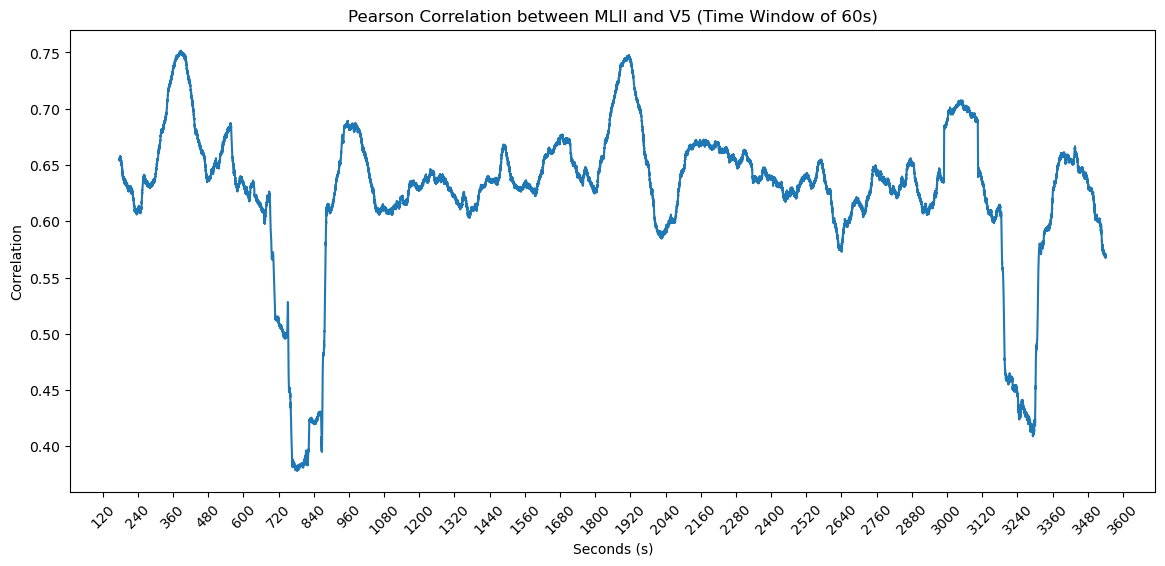

In [ ]:
### Attempt 2 using different method:

## doingn it reversed jkust incase it looked different

plt.figure(figsize=(14, 6))

pearson = df_V5.rolling(window = (60 * Fs), center = True).corr(df_MLII)
plt.plot(pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between V5 and MLII (Time Window of 60s)')
plt.xticks(rotation = 45)
xticks = np.linspace(0,  650000, 30)
plt.xticks(xticks, ['120', '240', '360', '480', '600', '720', '840', '960', '1080', '1200', '1320', '1440', 
                    '1560', '1680', '1800', '1920', '2040', '2160', '2280', '2400', '2520', '2640', '2760', '2880', '3000', '3120', '3240', '3360', '3480', '3600'])
plt.show()